In [1]:
import numpy as np
import utm
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
file = open("../boat_outlines/tech/tech_coords_final.csv")
outline = np.loadtxt(file, delimiter=",")
file.close()


In [3]:
# set up packet for boat position
lat = 42.432655
lon = -71.393313
mag_head = -14.063

packet = {}
packet["latitude"] = lat
packet["longitude"] = lon
packet["raw_magnetic_heading"] = mag_head



In [4]:
def plot_outline(a):
    fig, ax = plt.subplots(1, figsize=(8,8))
    plt.scatter(a[:,0],a[:,1])
    ax.set_aspect('equal')

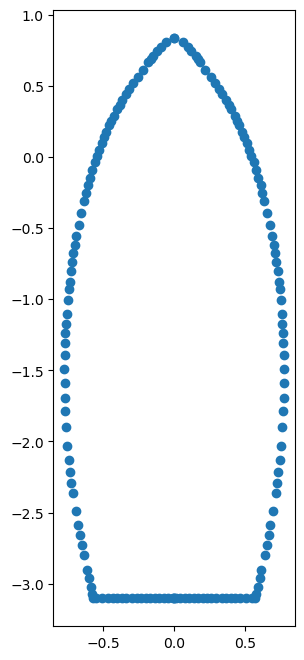

In [5]:
plot_outline(outline)

In [7]:
# set up line

e, n, _,_= utm.from_latlon((lat + .00003), (lon + .00001))
rc = np.array([e, n])

e, n, _,_= utm.from_latlon((lat - .00002), (lon - .00001))
pin = np.array([e, n])

line = np.array([rc, pin])


In [8]:
from magnetic_field_calculator import MagneticFieldCalculator

def make_rotation_matrix(radians):
    return np.asarray(
        [np.cos(radians), -np.sin(radians), np.sin(radians), np.cos(radians)]
    ).reshape(2, 2)


def rotate_points(points, degrees, origin=(0, 0)):  # looks good
    R = make_rotation_matrix(np.radians(-degrees))
    o = np.atleast_2d(origin)
    p = np.atleast_2d(points)

    return np.squeeze((R @ (p.T - o.T) + o.T).T)


MAGNETIC_DEC_CACHE = {}


def get_magnetic_offset(latitude, longitude, zone=None):
    if zone is None:
        _, _, zone, _ = utm.from_latlon(latitude, longitude)

    try:
        dec = MAGNETIC_DEC_CACHE[zone]
    except KeyError:
        calculator = MagneticFieldCalculator()
        out = calculator.calculate(latitude, longitude)
        field_value = out['field-value']
        dec = field_value['declination']['value']
        MAGNETIC_DEC_CACHE[zone] = dec
    return dec


In [9]:
get_magnetic_offset(42+58/60, -(73 + 50/60))  # should be ~ -13.15

-13.148

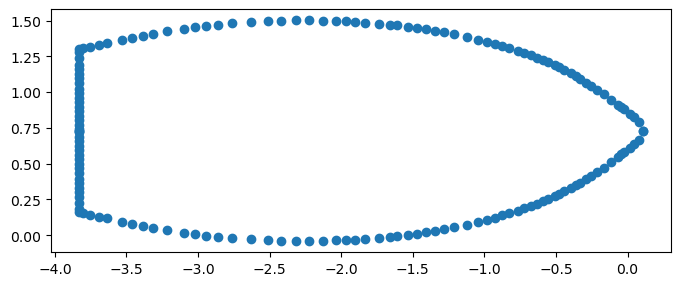

In [10]:
tmp = np.copy(outline)
tmp_out = rotate_points(tmp, 90, [0,.73])
plot_outline(tmp_out)

In [11]:
def orient_boat_outline(   # does what it says - not for accounting for the gps antenna offset
    standard_outline_array, x_offset, y_offset, orientation
):
    """
    Orient a boat outline to be rotated about [0,0] according to the specified orientation
    angle and then translate the outline by the specified X and Y offsets.

    Parameters
    ----------
    standard_outline_array: np.ndarray((N, 2))
        The 2D outline array. The columns of this array should be the spatial
        axis of the outline.

    x_offset: float
        The meter offset in the X dimension (added)
    y_offset: float
        The meter offset in the Y dimension (added)

    orientation: float
        The degree angle to rotate the outline (CW)
    """
    rotated_outline = rotate_points(
        np.copy(standard_outline_array), orientation
    )
    ######  think that the acounting of the offset needs to happen prior to the rotation
    rotated_outline[:, 0] = rotated_outline[:, 0] + x_offset
    rotated_outline[:, 1] = rotated_outline[:, 1] + y_offset

    return rotated_outline


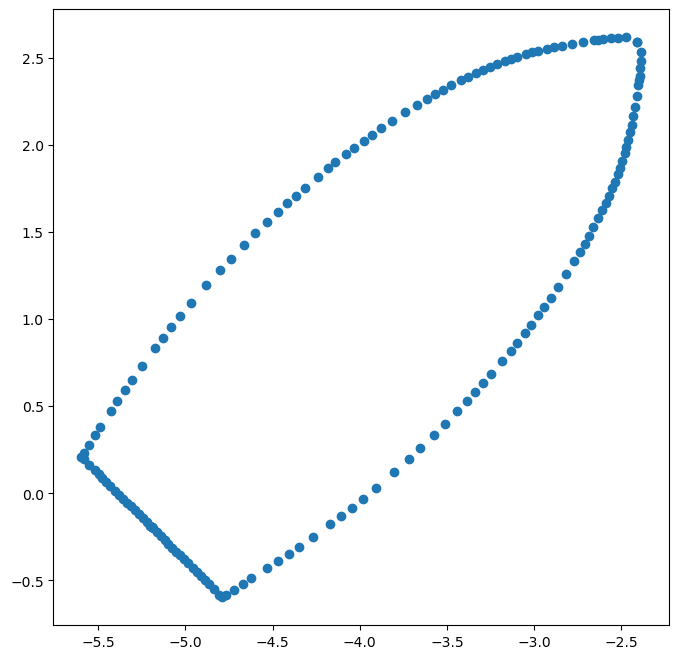

In [12]:
tmp = np.copy(outline)
tmp_out = orient_boat_outline(tmp, -3,2,45)
plot_outline(tmp_out)

In [13]:
def standardized_line(line_array, this_point = None):  #works as advertised
    """
    Center the given line on the first element of the array and rotate the
    line such that the Y axis is flattened.

    Returns
    -------
    rotated_other: (x, y)
        The rotated and translated line point. The origin of the line will
        be centered on (0, 0)
    line_angle:
        The degree rotation used to orient the line such that it lies flat
        on the Y axis.
    vector:
        The vector used to translate the origin to (0, 0) (added).
    rotated point (optional): 
        A rotated and translated single point.
    """
    origin = line_array[0]
    other = line_array[1]

    #logger.info(f"origin: {origin}, other: {other}, this_point: {this_point}")
    translated_other = other - origin
 
    ref = np.pi / 2
    line_angle = np.degrees(
        ref - np.arctan2(translated_other[1], translated_other[0])
    )
    rotated_other = rotate_points(translated_other, -line_angle)
    #logger.info(f"this_point == [-1,-1]: {str(this_point == [-1,-1])}")
    if isinstance(this_point, type(None)):
        return rotated_other + origin, line_angle, -1 * origin
    else:
        translated_point = this_point - origin
        rotated_point = rotate_points(translated_point, -line_angle)   
        return rotated_other + origin, line_angle, -1 * origin, rotated_point + origin


In [14]:
#standardized_line([np.array([1,0]),np.array([4,4])], np.array([4,4]))
standardized_line([np.array([1,0]),np.array([4,4])])

(array([1., 5.]), 36.86989764584402, array([-1,  0]))

In [15]:
def center_line_and_outline(
    outline, line, easting, northing, magnetic_heading
):
    rotated_rc, line_angle, origin_vector = standardized_line(line)
    oriented_outline = orient_boat_outline(
        outline, easting, northing, magnetic_heading - line_angle
    )

    return rotated_rc, oriented_outline, line_angle


[ 2.         10.48528137],  45.0


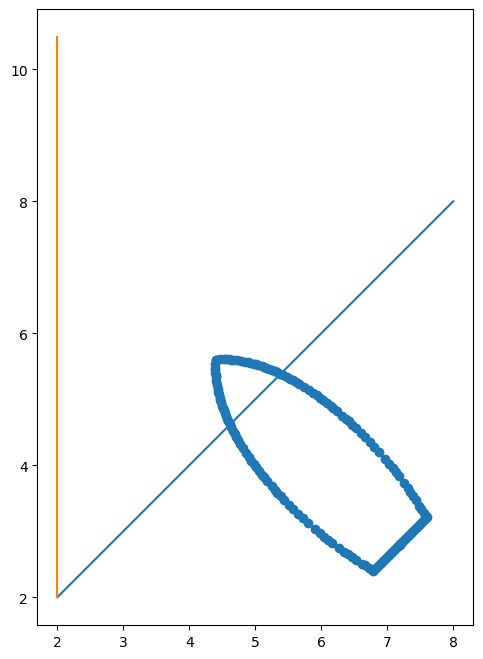

In [16]:
tmp = np.copy(outline)
tmp_line = np.array([np.array([2, 2]), np.array([8, 8])])

r_rc, r_t_outline, line_angle = center_line_and_outline(tmp, tmp_line, 5, 5, 0)
print(f"{r_rc},  {line_angle}")
fig, ax = plt.subplots(1, figsize=(8,8))
plt.plot(tmp_line[:,0],tmp_line[:,1])
plt.plot([tmp_line[0,0], r_rc[0]],[tmp_line[0,1], r_rc[1]])
plt.scatter(r_t_outline[:,0],r_t_outline[:,1])
ax.set_aspect('equal')


In [92]:
def calculate_distances(packet):
            
    boat_pos = [packet["easting"],packet["northing"]]   # device boat pos
    test_rc, _, _, rot_boat_pos = standardized_line(line, boat_pos)  # returns are rotated around line[0] with line along y axis
                        
    rotated_rc, oriented_outline, rot_angle = center_line_and_outline(   # test_rc == rotated_rc
        outline,
        line,
        packet["easting"],
        packet["northing"],
        packet["adj_magnetic_heading"],
    )
    print(f"test_rc: {test_rc}   rotated_rc: {rotated_rc}")
    #fig, ax = plt.subplots(1, figsize = (8,8))
    #plt.scatter(oriented_outline[:,0],oriented_outline[:,1])
    #plt.scatter(packet["easting"],packet["northing"])
    #plt.plot([line[0,0], test_rc[0]], [line[0,1], test_rc[1]])
    #ax.set_aspect('equal')
    
    ref_axis = rotated_rc[0]
    #print(f"line[0]: {line[0]}, ref_axis: {ref_axis}")
    #min_bound = np.min(oriented_outline[:, 1])
    #max_bound = np.max(oriented_outline[:, 1])
    #distance = min(
    #    np.abs(ref_axis - min_bound), np.abs(ref_axis - max_bound)
    #)
    
    translated_oriented_outline = rotate_points(oriented_outline,-rot_angle,line[0,:])
    distance = max(translated_oriented_outline[:, 0]) - ref_axis
            
    #logger.info(f"test_rc: {str(test_rc)}, rot_rc: {str(rotated_rc)}, ref_axis: {str(ref_axis)}, dist: {str(distance)}")
    #logger.info(f"line: {str(line)}, \n rot_boat_pos: {rot_boat_pos}")
            
    # plot things
            
    # fig, ax = plt.subplots(1, figsize = (8,8))
    # plt.ion()
                        
    # # plot the rotated starting line
    # ax.plot(line[:,0],rotated_rc)
    # # plot the boat sensor location
    # ax.scatter(rot_boat_pos[0],rot_boat_pos[1], s=[128], c =['g'])
    # # plot the boat outline
    # ax.plot(oriented_outline[:,0], oriented_outline[:,1], 'bo', markersize=2)
    # ax.set_aspect('equal')
    # #plt.show()
    # plt.pause(1)
    # plt.close()
            
    print(f"line[0]: {line[0]}, test_rc: {test_rc}")
    fig, ax = plt.subplots(1, figsize = (8,8))
    plt.plot(line[:,0],line[:,1], c='b')
    plt.scatter(line[0,0],line[0,1], s=[128], c =['b'], marker = '$RC$')
    plt.scatter(line[1,0],line[1,1], s=[128], c =['b'], marker = '$pin$')
    plt.scatter(boat_pos[0], boat_pos[1], c = 'b')
    plt.scatter(oriented_outline[:,0], oriented_outline[:,1], c='b')
    plt.plot([line[0,0], test_rc[0]], [line[0,1], test_rc[1]], c='r')
    plt.scatter(test_rc[0],test_rc[1], s=[128], c =['r'], marker = '$pin$')
    plt.scatter(rot_boat_pos[0],rot_boat_pos[1], c = 'r')
    plt.scatter(translated_oriented_outline[:,0], translated_oriented_outline[:,1], c='r')
    ax.set_aspect('equal')

        
    print (f"distance: {distance}")

test_rc: [ 303135.52915425 4700599.40791377]   rotated_rc: [ 303135.52915425 4700599.40791377]
line[0]: [ 303135.52915425 4700593.61468627], test_rc: [ 303135.52915425 4700599.40791377]
distance: 2.1355034633306786


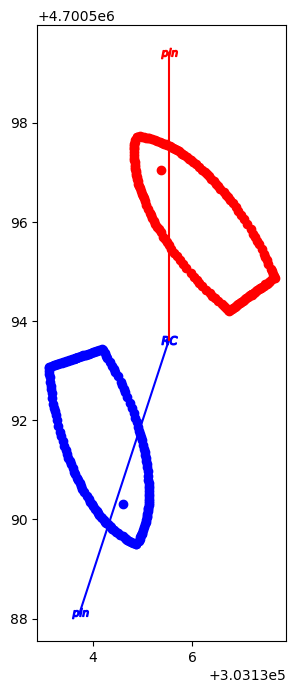

In [93]:
calculate_distances(packet)

test_rc: [ 303135.52915425 4700599.40791377]   rotated_rc: [ 303135.52915425 4700599.40791377]
line[0]: [ 303135.52915425 4700593.61468627], test_rc: [ 303135.52915425 4700599.40791377]
distance: 2.1355034633306786


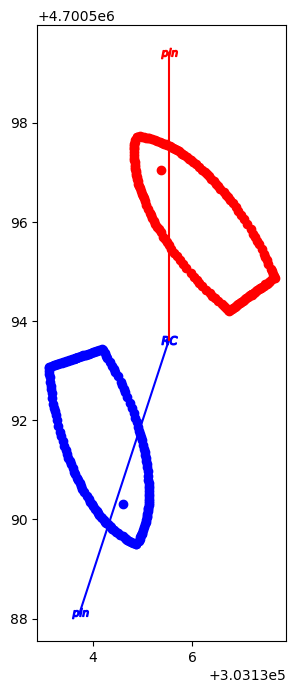

In [94]:
# from process_packet in packet.py

easting, northing, zone_number, zone_letter = utm.from_latlon(
    packet["latitude"], packet["longitude"]
)
packet["easting"] = easting   # from device
packet["northing"] = northing  # from device
packet["zone_number"] = zone_number
packet["zone_letter"] = zone_letter

raw_magnetic_heading = packet["raw_magnetic_heading"]   # from device
magnetic_dec = get_magnetic_offset(
    packet["latitude"], packet["longitude"], packet["zone_number"]
)
adjusted_magnetic_heading = raw_magnetic_heading - magnetic_dec
packet["adj_magnetic_heading"] = adjusted_magnetic_heading

calculate_distances(packet)

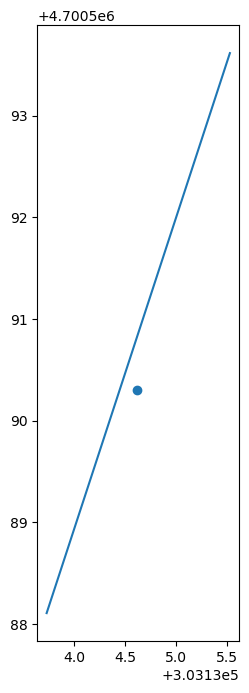

In [19]:
    fig, ax = plt.subplots(1, figsize = (8,8))
    #plt.scatter(oriented_outline[:,0],oriented_outline[:,1])
    plt.scatter(packet["easting"],packet["northing"])
    plt.plot(line[:,0], line[:,1])
    ax.set_aspect('equal')


In [ ]:
packet

In [ ]:
line

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,8))
plt.plot(line[:,0],line[:,1])
plt.scatter(packet['easting'], packet['northing'])
ax.set_aspect('equal')